<a href="https://colab.research.google.com/github/umbertoselva/diamond-price-estimator/blob/main/Diamond_pycaret_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DIAMOND PRICE ESTIMATOR

The goal of this notebook is to train a model with PyCaret to estimate the price of diamonds based on a set of features.

I shall use the `diamond` database available with PyCaret.

The trained model can be found as a .pkl file in the same directory as this notebook. I then use this model in the diamond.py app.

N.B. This notebook is largely based on PyCaret's official tutorial on Regression.

In [1]:
# pycaret is supported for python 3.6 - 3.8
!python --version

Python 3.7.15


In [2]:
!pip install pycaret --quiet

In [3]:
# restart runtime before running the following
from pycaret.regression import *

### THE DATASET

In [4]:
# list of available datasets:
# https://github.com/pycaret/datasets/tree/main/data/common

from pycaret.datasets import get_data
dataset = get_data('diamond')

# dataset is a pandas DataFrame

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171


* **ID**: Uniquely identifies each observation (i.e. diamond)
* **Carat Weight**: The weight of the diamond in metric carats. One carat is equal to 0.2 grams.
* **Cut**: One of five values indicating the cut of the diamond in the following order of desirability (Signature-Ideal, Ideal, Very Good, Good, Fair).
* **Color**: One of six values indicating the diamond's color in the following order of desirability (D, E, F - Colorless, G, H, I - Near colorless).
* **Clarity**: One of seven values indicating the diamond's clarity in the following order of desirability (F - Flawless, IF - Internally Flawless, VVS1 or VVS2 - Very, Very Slightly Included, or VS1 or VS2 - Very Slightly Included, SI1 - Slightly Included).
* **Polish**: One of four values indicating the diamond's polish (ID - Ideal, EX - Excellent, VG - Very Good, G - Good).
* **Symmetry**: One of four values indicating the diamond's symmetry (ID - Ideal, EX - Excellent, VG - Very Good, G - Good).
* **Report**: One of of two values "AGSL" or "GIA" indicating which grading agency reported the qualities of the diamond qualities.
* **Price**: The amount in USD that the diamond is valued.

In [5]:
type(dataset)

pandas.core.frame.DataFrame

### PRE-PROCESSING

#### 1) EXPLORATORY ANALYSIS

We can carry out an exploratory analysis of the database to see what kind of pre-processing it needs. 

To do so can generate a report on the database:


In [ ]:
dataset = get_data('diamond', profile=True)

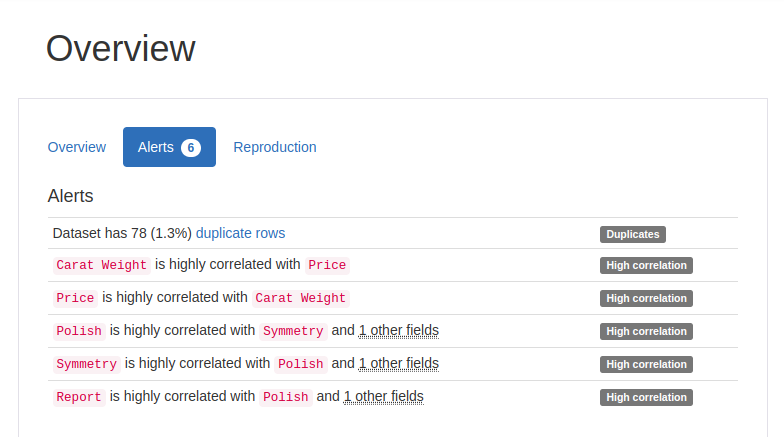

If we look at the **Alerts** tab within the **Overview** section, we can see that
* The report identifies high correlation between the `Price` and the `Carat Weight` variables. This is also visible below from the **Interactions** section plot.
* There is also high-correlation between other variables ("multicollinearity").
* There is a 1.3% of duplicate rows that we might want to remove.
* By looking at the distribution of the `Carat Weight` variable, we might think of applying some normalization and data transformation. 

We can solve these issue below within the `.setup()` function during pre-processing, by setting the `normalization`, `transformation`,  `remove_multicollinearity` parameters to `True`.

#### 2) TRAIN, TRAIN-DEV SETS SETUP

We first split our 6000-row dataset and reserve 90% for training and 10% for testing:
* training set (`data`) on which we will train and tune our model (5400 examples)
* test set (`data_unseen`) (600 examples)

N.B. When we later apply `setup()` to our training set `data`, it will split it reserving 70% of it for training and 30% for validation/testing (these percentages can be changed by setting the `train_size` parameter).

So we will eventually have:
* training set = 3779 examples for training the model
* cross-validation = 1621 examples for tuning the model
* test set = 600 examples of unseen data for a further final testing


In [7]:
dataset

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171
...,...,...,...,...,...,...,...,...
5995,1.03,Ideal,D,SI1,EX,EX,GIA,6250
5996,1.00,Very Good,D,SI1,VG,VG,GIA,5328
5997,1.02,Ideal,D,SI1,EX,EX,GIA,6157
5998,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,11206


Let's use pandas DataFrame.sample() function to split our dataset into a training set (data) and a training-dev set (data)

We set `random_state` so that the split result will be reproduceable

In [8]:
data = dataset.sample(frac=0.9, random_state=786)
data_unseen = dataset.drop(data.index)

In [9]:
data

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
5333,1.50,Good,E,VS2,VG,G,GIA,12702
3749,1.08,Ideal,D,VS2,EX,EX,GIA,8481
2376,2.25,Good,I,VS2,G,VG,GIA,18623
3756,2.27,Very Good,G,VS2,VG,VG,GIA,27252
4248,1.20,Ideal,F,VS1,EX,EX,GIA,9641
...,...,...,...,...,...,...,...,...
1248,0.80,Ideal,E,VS1,VG,VG,GIA,3714
5299,1.02,Very Good,E,SI1,VG,EX,GIA,5424
4979,1.03,Ideal,F,VS2,VG,VG,GIA,6997
933,2.01,Good,H,VS1,VG,VG,GIA,18988


In [10]:
data_unseen

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
5,1.53,Ideal,E,SI1,ID,ID,AGSL,12791
7,1.50,Fair,F,SI1,VG,VG,GIA,10450
11,1.01,Good,E,SI1,G,G,GIA,5161
13,2.51,Very Good,G,VS2,VG,VG,GIA,34361
18,1.01,Good,I,SI1,VG,VG,GIA,4238
...,...,...,...,...,...,...,...,...
5973,1.02,Very Good,F,SI1,G,G,GIA,5430
5975,2.05,Good,G,VS1,G,VG,GIA,26297
5976,2.01,Very Good,E,VS2,EX,VG,GIA,27002
5995,1.03,Ideal,D,SI1,EX,EX,GIA,6250


The initial dataset was split into the two sets, but each row has kept its own index, so we now reset the index numbers for the two new sets

In [11]:
data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

In [12]:
data

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.50,Good,E,VS2,VG,G,GIA,12702
1,1.08,Ideal,D,VS2,EX,EX,GIA,8481
2,2.25,Good,I,VS2,G,VG,GIA,18623
3,2.27,Very Good,G,VS2,VG,VG,GIA,27252
4,1.20,Ideal,F,VS1,EX,EX,GIA,9641
...,...,...,...,...,...,...,...,...
5395,0.80,Ideal,E,VS1,VG,VG,GIA,3714
5396,1.02,Very Good,E,SI1,VG,EX,GIA,5424
5397,1.03,Ideal,F,VS2,VG,VG,GIA,6997
5398,2.01,Good,H,VS1,VG,VG,GIA,18988


In [13]:
data_unseen

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.53,Ideal,E,SI1,ID,ID,AGSL,12791
1,1.50,Fair,F,SI1,VG,VG,GIA,10450
2,1.01,Good,E,SI1,G,G,GIA,5161
3,2.51,Very Good,G,VS2,VG,VG,GIA,34361
4,1.01,Good,I,SI1,VG,VG,GIA,4238
...,...,...,...,...,...,...,...,...
595,1.02,Very Good,F,SI1,G,G,GIA,5430
596,2.05,Good,G,VS1,G,VG,GIA,26297
597,2.01,Very Good,E,VS2,EX,VG,GIA,27002
598,1.03,Ideal,D,SI1,EX,EX,GIA,6250


#### 3) PRE-PROCESSING

For info on these parameter see: https://pycaret.readthedocs.io/en/stable/api/regression.html

* `data` = the training dataset.
* `target` = the target variable which we want to predict.
* `session_id` = used for reproducibility (equivalent to random_state in scikit-learn).
* `normalize` = to apply normalization (zscore by default).
* `transformation` = to execute data transformation on the training set to make data more Gaussian-like (yeo-johnson by default).
* `transforma_target` = to execute the same on the target variable too.
* `combine_rare_levels` = When set to True, frequency percentile for levels in categorical features below a certain threshold (`rare_level_threshold`) is combined into a single level.
* `remove_multicollinearity` = When set to True, features with the inter-correlations higher than the defined threshold (`multicollinearity_threshold`) are removed. When two features are highly correlated with each other, the feature that is less correlated with the target variable is removed. Only considers numeric features.
* `bin_numeric_features` = This transformation divides (discretizes) a numerical variable values into groups and labels them with categorical labels. It does so by using ‘sturges’ rule to determine the number of clusters and then applies KMeans. The original values of the feature are then replaced by the cluster label. The resulting group labels are more informative than the original values themselves.
* `log_experiment` and `experiment_name` are necessary for model registration and versioning.
* `silent` = When `setup()` is executed, PyCaret will automatically infer the data types for all features and it displays them in a table. When `Silent` is set to False (default), PyCaret will ask to input `enter` to continue after confirming that all data types have been identified correctly or `quit` to end. Set `silent` to True when executing in completely automated mode or on a remote kernel.

N.B. As already said above, `setup()` automatically splits the training set, reserving 70% of it for training and 30% for cross-validation (these percentages can be changed by setting the `train_size` parameter).

The resulting dimensions of the training and cross-validation set can be read under `Transformed Train Set` and `Transformed Test Set`. Note that although the original data had 8 columns, these split sets have 39. That's because of the transformations that we have applied (e.g. bin_numeric_features) and the new categorical encodings that have been created by them.


In [14]:
s = setup(data=data, 
          target='Price', 
          session_id=123, 
          normalize=True, 
          transformation=True, 
          transform_target=True, 
          combine_rare_levels=True, 
          rare_level_threshold=0.05, 
          remove_multicollinearity=True, 
          multicollinearity_threshold=0.95, 
          bin_numeric_features=['Carat Weight'], 
          log_experiment=True, 
          experiment_name='diamond01',
          silent=True) 

,Description,Value
0,session_id,123
1,Target,Price
2,Original Data,"(5400, 8)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3779, 39)"


INFO:logs:Logging experiment in MLFlow
2022/11/20 18:59:43 INFO mlflow.tracking.fluent: Experiment with name 'diamond01' does not exist. Creating a new experiment.
INFO:logs:SubProcess save_model() called ==================================
INFO:logs:Initializing save_model()
INFO:logs:save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='Price',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy=...
                ('dumm

### MODEL TRAINING

#### 1) COMPARING REGRESSION MODELS

With the `compare_models()` function we can evaluate the performance of all available estimators by training them using cross-validation.

In [15]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,766.0853,3.116467e+06,1704.0975,0.9704,0.0799,0.0576,0.147
rf,Random Forest Regressor,850.1194,3.267554e+06,1770.6698,0.9686,0.0904,0.0657,1.060
huber,Huber Regressor,940.6199,3.651906e+06,1891.7125,0.9640,0.0972,0.0708,0.161
ridge,Ridge Regression,952.2538,3.846278e+06,1934.6314,0.9624,0.0971,0.0715,0.026
br,Bayesian Ridge,956.6502,3.999160e+06,1967.8153,0.9608,0.0972,0.0716,0.032
lr,Linear Regression,960.2937,4.046533e+06,1978.6945,0.9604,0.0973,0.0717,0.316
et,Extra Trees Regressor,964.4979,4.410739e+06,2062.2772,0.9569,0.1055,0.0759,1.218
dt,Decision Tree Regressor,1000.2500,4.685153e+06,2136.9863,0.9539,0.1082,0.0778,0.040
gbr,Gradient Boosting Regressor,1107.4885,5.269003e+06,2255.3276,0.9486,0.1100,0.0832,0.292
par,Passive Aggressive Regressor,1341.4005,7.149373e+06,2588.2842,0.9288,0.1282,0.0964,0.031


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 2
INFO:logs:PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=1...
                                                        importance_type='split',
                                                        learning_rate=0.1,
                                                        max_depth=-1,
                                  

#### 2) OPTIMIZING

The `lightgbm` model (Light Gradient Boosting Machine, `lightgbm.sklearn.LGBMRegressor`) has performed best, with 0.9704 as the R2 metric, so let's fully train it with the `tune_model()` function, which optimizes the parameters based on the R2 metric results for a default of 10 iterations. The output is a table of the performance on 10 folds (with kfold as the default fold strategy on cross-validation).

In [16]:
tuned_best = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1072.0825,5.208644e+06,2282.2454,0.9428,0.1056,0.0783
1,1168.0408,1.018465e+07,3191.3394,0.9219,0.1012,0.0746
2,1066.8059,4.198594e+06,2049.0471,0.9615,0.1006,0.0768
3,1046.6599,3.769540e+06,1941.5303,0.9584,0.1027,0.0766
4,950.6577,3.097542e+06,1759.9836,0.9614,0.1055,0.0761
5,1161.4496,9.649674e+06,3106.3924,0.9176,0.1055,0.0760
6,1191.7385,8.448577e+06,2906.6436,0.9206,0.1095,0.0806
7,1015.7054,3.969739e+06,1992.4203,0.9498,0.1031,0.0760
8,1052.3919,4.944537e+06,2223.6314,0.9514,0.1003,0.0730


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 3
INFO:logs:PowerTransformedTargetRegressor(bagging_fraction=0.9, bagging_freq=3,
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.5,
                                importance_type='split', learning_rate=0.4,
                                max_depth=-1, min_child_samples=6,
                                min_child_weight=0.001, min_split_gain=0.3,
                                n_estimators=20, n_jobs=-1, num_leaves=150,
                                objective=None,
                                power_transformer_method='bo...
                                                        importance_type='split',
                                                        learning_rate=0.4,
                                                        max_depth=-1,
                                 

Whereas the R2 predicted by model comparison was 0.9704, the result mean after training on 10 folds was 0.9421.

Let's see if we can improve this by tweaking the learning rate, which is 0.1 by default. To do this, we need to create an instance of a lightgbm model and then pass it our custom hyperparameters.

In [17]:
import numpy as np

lgbm_params = {'learning_rate': np.arange(0.1,1,0.1)}

lightgbm = create_model('lightgbm')

tuned_lightgbm = tune_model(lightgbm, custom_grid = lgbm_params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,749.3501,1.808911e+06,1344.9578,0.9801,0.0818,0.0602
1,831.2409,3.644931e+06,1909.1704,0.9721,0.0770,0.0571
2,791.4986,2.794176e+06,1671.5788,0.9744,0.0828,0.0597
3,739.8431,1.586810e+06,1259.6865,0.9825,0.0755,0.0579
4,705.6508,1.727679e+06,1314.4121,0.9785,0.0803,0.0580
5,800.4593,5.649070e+06,2376.7772,0.9518,0.0786,0.0549
6,898.2628,3.786049e+06,1945.7771,0.9644,0.0867,0.0629
7,779.1007,2.658242e+06,1630.4117,0.9664,0.0815,0.0592
8,711.0207,1.735966e+06,1317.5608,0.9830,0.0751,0.0568


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 5
INFO:logs:PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.4, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=1...
                                                        importance_type='split',
                                                        learning_rate=0.4,
                                                        max_depth=-1,
                                  

With this we got a result R2 mean of 0.9725.

### TESTING

Let us test our model on the cross-validation set (the 30% of the original database, 1621 examples) and compare the result with the 0.9725 result of our training.

In [18]:
predict_model(tuned_lightgbm)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.4, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=1...
                                                        importance_type='split',
                                                        learning_rate=0.4,
                                                        max_depth=-1,
                                                        min_child_samples=20

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,808.2165,2.974172e+06,1724.5787,0.9729,0.0792,0.0593


,Cut_Fair,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Color_D,Color_E,Color_F,Color_G,Color_H,...,Carat Weight_2.0,Carat Weight_3.0,Carat Weight_4.0,Carat Weight_5.0,Carat Weight_6.0,Carat Weight_7.0,Carat Weight_8.0,Carat Weight_9.0,Price,Label
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7059,6410.654429
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5809,5889.379498
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10641,10995.342268
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2871,2710.580270
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21706,21445.046979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12906,13639.269565
1617,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3235,3435.121144
1618,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9058,9337.107596
1619,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5091,4895.249451


Our training mean was 0.9725 and here we got 0.9729.

Lastly, we finalize the model by fitting it on the whole training set (5400 examples, 70% + 30%). We will then test it on the test set (600 examples).

In [19]:
final_lightgbm = finalize_model(tuned_lightgbm)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.4, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=1...
                                                        importance_type='split',
                                                        learning_rate=0.4,
                                                        max_depth=-1,
                                                        min_child_samples=

In [20]:
print(final_lightgbm)

PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.4, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=1...
                                                        importance_type='split',
                                                        learning_rate=0.4,
                                                        max_depth=-1,
                                                        min_child_samples=20,
                                                        min_child_weigh

Finally, we test on unseen data (the 10% of the original database that we split in the beginning: 600 examples)

In [21]:
unseen_predictions = predict_model(final_lightgbm, data=data_unseen)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.4, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=1...
                                                        importance_type='split',
                                                        learning_rate=0.4,
                                                        max_depth=-1,
                                                        min_child_samples=20

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,770.205,2.271855e+06,1507.2673,0.9779,0.0731,0.0557


The final performance is a 0.9779 on the R2 metrics on unseen data.

In [22]:
from pycaret.utils import check_metric
check_metric(unseen_predictions.Price, unseen_predictions.Label, 'R2')

0.9779

### SAVING THE MODEL

We save the model in the current folder as a pickle file for later use.

In [23]:
save_model(final_lightgbm,'Diamond_Estimator_LightGBM')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.4, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=1...
                                                        importance_type='split',
                                                        learning_rate=0.4,
                                                        max_depth=-1,
                                                        min_child_samples=20,
        

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Price',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy=...
                                                                          learning_rate=0.4,
                                                                          max_depth=-1,
                                                                          min_child_samples=20,
                                    